# **Komering Script Character Recognition**

In [1]:
# Import Library
import os
import cv2
import PIL
import json
import time
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import torch.nn as nn
from torchvision import models
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import models
from torch.nn import functional as F
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Load Dataset
image = []
label = []

for dirname, _, filenames in os.walk('/content/drive/MyDrive/Proyek/Computer Vision/Komering Character/Data'):
  for filename in filenames:
    if filename.endswith('.png') or filename.endswith('.jpg'):
      image.append(os.path.join(dirname, filename).split('/')[-1])
      label.append(os.path.join(dirname, filename).split('/')[-2])

In [3]:
# Load images dataset
IMAGE_PATH = '/content/drive/MyDrive/Proyek/Computer Vision/Komering Character/Data/'

In [4]:
df_full = pd.DataFrame({'image_id':image, 'label':label})

# FINDING BAD FILE

index = []
for i in range(len(df_full)):
    try:
        Image.open(IMAGE_PATH + str(df_full['label'].values[i]) + '/' + str(df_full['image_id'].values[i]))

    except PIL.UnidentifiedImageError:
        index.append(i)

df = df_full.drop(index)
df.head()

,image_id,label
0,A (7).jpg,a
1,A (5).jpg,a
2,A (14).png,a
3,A (5).png,a
4,A (30).jpg,a


In [5]:
label = ['a', 'ba', 'ca', 'da', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'mba',
         'mpa', 'na', 'nca', 'nda', 'nga', 'ngka', 'nja', 'pa', 'ra', 'rha-gha',
         'sa', 'ta', 'wa', 'ya']

ints = np.arange(0, len(label))
dicts = dict(zip(label, ints))

In [10]:
class Komering(Dataset):
  def __init__(self, x, y, path, maps_label = dicts, transform=None):
    self.X = x
    self.y = y
    self.path = path
    self.dicts = maps_label
    self.transform = transform

  def __getitem__(self, idx):
    # Ensure the image is in RGB format for consistency with a 3-channel model input
    img = Image.open(self.path + str(self.y[idx]) + '/' + str(self.X[idx])).convert('RGB')
    label = self.y[idx]
    label = self.label_2_ints(label)

    if self.transform is not None:
      img = self.transform(img)

    return img, label

  def label_2_ints(self, x):
    label_id = None
    for key, values in self.dicts.items():
      if x == key:
        label_id = values
    return label_id

  def __len__(self):
    return len(self.X)

In [11]:
# Splitting train and test images
X_trainval, X_test, y_trainval, y_test = train_test_split(df['image_id'].values, df['label'].values,
                                                          test_size = 0.2, stratify = df['label'].values,
                                                          random_state = 8)

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval,
                                                  stratify = y_trainval, test_size = 0.2,
                                                  random_state = 8)
len(X_train), len(X_val), len(X_test)

(764, 192, 240)

In [12]:
# Data Augmentation
"""Transform images to tensor with resize, rotation and cropping images"""
train_transform = T.Compose([T.Resize((50, 50)),
                             T.RandomRotation((5, 30)),
                             T.RandomAffine((0, 50)),
                             T.RandomCrop(size=(50, 50)),
                             T.ToTensor()])

val_transform = T.Compose([T.Resize((50, 50)),
                           T.ToTensor()])

train_set = Komering(X_train, y_train, IMAGE_PATH, transform = train_transform)
val_set = Komering(X_val, y_val, IMAGE_PATH, transform = val_transform)
test_set = Komering(X_test, y_test, IMAGE_PATH, transform = val_transform)

BATCH_SIZE = 64
train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_set, batch_size = BATCH_SIZE, shuffle = False)

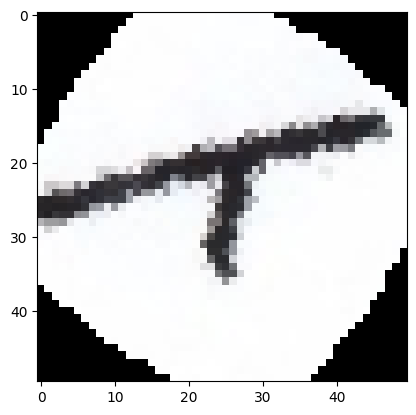

In [13]:
img, label = train_set[random.randint(0, len(X_train))]

plt.imshow(img.permute(1, 2, 0))

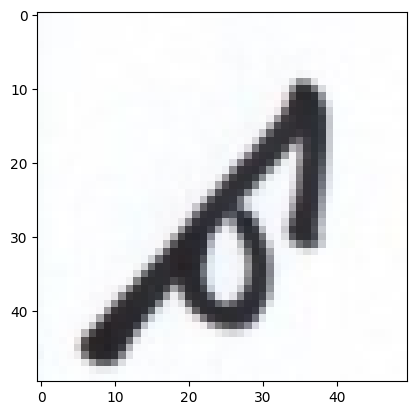

In [14]:
img, label = test_set[random.randint(0, len(X_test))]

plt.imshow(img.permute(1, 2, 0))

In [15]:
# Modelling using ResNet18
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(in_features = 512, out_features = len(dicts), bias = True)
#model.classifier[6] = nn.Linear(4096, 20)
model

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
# Accuracy
def accuracy(output, label):
  with torch.no_grad():
    output = torch.argmax(F.softmax(output, dim=1), dim=1)
    correct = torch.eq(output, label).int()
    accuracy = float(correct.sum()) / float(correct.numel())
  return accuracy

In [17]:
epoch = 50
# Learning rate with 0.001
lr = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = lr, epochs=epoch,
                                               steps_per_epoch=len(train_loader))

In [18]:
train_losses = []
val_losses =[]
train_accuracy = []
val_acc = []

for e in range(epoch):
  model.to(device)
  model.train()

  train_loss = 0
  train_acc = 0
  since = time.time()

  for image, label in tqdm(train_loader, total=len(train_loader)):
    optimizer.zero_grad()

    image = image.to(device)
    label = label.to(device)

    output = model(image)
    loss = criterion(output, label)

    train_loss += loss
    train_acc += accuracy(output, label)

    loss.backward()
    optimizer.step()


    scheduler.step()

  else:
    with torch.no_grad():
      model.eval()

      running_loss = 0
      val_accuracy = 0

      for image, label in val_loader:
        image = image.to(device)
        label = label.to(device)

        output = model(image)
        loss = criterion(output, label)
        val_accuracy += accuracy(output, label)
        running_loss += loss

  train_losses.append((train_loss/len(train_loader)).item())
  val_losses.append((running_loss/len(val_loader)).item())
  train_accuracy.append(train_acc/ len(train_loader))
  val_acc.append(val_accuracy/len(val_loader))

  print('epochs {}/{}..'.format(e+1, epoch),
        'train loss {:.3f}..'.format(train_loss/len(train_loader)),
        'val loss {:.3f}..'.format(running_loss/len(val_loader)),
        'train accuracy {:.3f}..'.format(train_acc/ len(train_loader)),
        'val accuracy {:.3f}..'.format(val_accuracy/len(val_loader)),
        'time {:.3f} s'.format(time.time() - since))

  0%|          | 0/12 [00:00<?, ?it/s]

epochs 1/50.. train loss 3.512.. val loss 3.441.. train accuracy 0.050.. val accuracy 0.026.. time 3.961 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 2/50.. train loss 3.133.. val loss 3.333.. train accuracy 0.122.. val accuracy 0.036.. time 3.610 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 3/50.. train loss 2.633.. val loss 3.253.. train accuracy 0.262.. val accuracy 0.062.. time 4.055 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 4/50.. train loss 2.106.. val loss 3.160.. train accuracy 0.416.. val accuracy 0.089.. time 3.647 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 5/50.. train loss 1.539.. val loss 3.042.. train accuracy 0.595.. val accuracy 0.135.. time 3.561 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 6/50.. train loss 1.024.. val loss 2.627.. train accuracy 0.719.. val accuracy 0.214.. time 3.676 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 7/50.. train loss 0.558.. val loss 1.909.. train accuracy 0.839.. val accuracy 0.500.. time 4.103 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 8/50.. train loss 0.479.. val loss 1.550.. train accuracy 0.856.. val accuracy 0.526.. time 3.625 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 9/50.. train loss 0.449.. val loss 1.493.. train accuracy 0.856.. val accuracy 0.568.. time 3.714 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 10/50.. train loss 0.440.. val loss 1.234.. train accuracy 0.873.. val accuracy 0.625.. time 4.133 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 11/50.. train loss 0.418.. val loss 1.207.. train accuracy 0.867.. val accuracy 0.641.. time 3.672 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 12/50.. train loss 0.385.. val loss 1.589.. train accuracy 0.863.. val accuracy 0.562.. time 3.524 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 13/50.. train loss 0.341.. val loss 1.175.. train accuracy 0.890.. val accuracy 0.693.. time 3.662 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 14/50.. train loss 0.325.. val loss 0.864.. train accuracy 0.903.. val accuracy 0.786.. time 4.093 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 15/50.. train loss 0.289.. val loss 1.432.. train accuracy 0.903.. val accuracy 0.630.. time 3.573 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 16/50.. train loss 0.272.. val loss 0.796.. train accuracy 0.916.. val accuracy 0.781.. time 3.532 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 17/50.. train loss 0.295.. val loss 1.002.. train accuracy 0.905.. val accuracy 0.714.. time 4.035 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 18/50.. train loss 0.193.. val loss 0.777.. train accuracy 0.939.. val accuracy 0.812.. time 3.681 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 19/50.. train loss 0.165.. val loss 0.709.. train accuracy 0.952.. val accuracy 0.812.. time 3.554 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 20/50.. train loss 0.094.. val loss 0.725.. train accuracy 0.967.. val accuracy 0.802.. time 3.665 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 21/50.. train loss 0.129.. val loss 0.783.. train accuracy 0.958.. val accuracy 0.766.. time 4.081 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 22/50.. train loss 0.211.. val loss 0.777.. train accuracy 0.939.. val accuracy 0.833.. time 3.548 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 23/50.. train loss 0.150.. val loss 1.244.. train accuracy 0.941.. val accuracy 0.719.. time 3.529 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 24/50.. train loss 0.124.. val loss 0.718.. train accuracy 0.958.. val accuracy 0.802.. time 4.034 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 25/50.. train loss 0.120.. val loss 0.613.. train accuracy 0.969.. val accuracy 0.807.. time 3.728 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 26/50.. train loss 0.113.. val loss 0.524.. train accuracy 0.969.. val accuracy 0.865.. time 3.541 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 27/50.. train loss 0.069.. val loss 0.331.. train accuracy 0.975.. val accuracy 0.927.. time 3.629 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 28/50.. train loss 0.065.. val loss 0.590.. train accuracy 0.975.. val accuracy 0.828.. time 4.185 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 29/50.. train loss 0.072.. val loss 0.463.. train accuracy 0.982.. val accuracy 0.891.. time 3.593 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 30/50.. train loss 0.047.. val loss 0.519.. train accuracy 0.988.. val accuracy 0.854.. time 3.546 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 31/50.. train loss 0.034.. val loss 0.419.. train accuracy 0.990.. val accuracy 0.875.. time 4.027 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 32/50.. train loss 0.042.. val loss 0.404.. train accuracy 0.986.. val accuracy 0.891.. time 3.687 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 33/50.. train loss 0.030.. val loss 0.324.. train accuracy 0.989.. val accuracy 0.922.. time 3.518 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 34/50.. train loss 0.019.. val loss 0.327.. train accuracy 0.997.. val accuracy 0.927.. time 3.503 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 35/50.. train loss 0.029.. val loss 0.393.. train accuracy 0.991.. val accuracy 0.922.. time 4.182 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 36/50.. train loss 0.025.. val loss 0.374.. train accuracy 0.993.. val accuracy 0.917.. time 3.543 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 37/50.. train loss 0.008.. val loss 0.336.. train accuracy 0.997.. val accuracy 0.938.. time 3.543 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 38/50.. train loss 0.016.. val loss 0.358.. train accuracy 0.997.. val accuracy 0.922.. time 3.993 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 39/50.. train loss 0.009.. val loss 0.357.. train accuracy 0.997.. val accuracy 0.911.. time 3.761 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 40/50.. train loss 0.008.. val loss 0.368.. train accuracy 1.000.. val accuracy 0.917.. time 3.545 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 41/50.. train loss 0.012.. val loss 0.376.. train accuracy 0.996.. val accuracy 0.922.. time 3.579 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 42/50.. train loss 0.006.. val loss 0.375.. train accuracy 0.999.. val accuracy 0.922.. time 4.207 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 43/50.. train loss 0.006.. val loss 0.367.. train accuracy 1.000.. val accuracy 0.911.. time 3.546 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 44/50.. train loss 0.008.. val loss 0.366.. train accuracy 0.999.. val accuracy 0.906.. time 3.560 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 45/50.. train loss 0.010.. val loss 0.355.. train accuracy 0.999.. val accuracy 0.917.. time 3.942 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 46/50.. train loss 0.009.. val loss 0.359.. train accuracy 0.999.. val accuracy 0.917.. time 3.834 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 47/50.. train loss 0.004.. val loss 0.363.. train accuracy 1.000.. val accuracy 0.906.. time 3.553 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 48/50.. train loss 0.006.. val loss 0.360.. train accuracy 0.999.. val accuracy 0.901.. time 3.552 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 49/50.. train loss 0.004.. val loss 0.346.. train accuracy 0.999.. val accuracy 0.922.. time 4.228 s


  0%|          | 0/12 [00:00<?, ?it/s]

epochs 50/50.. train loss 0.006.. val loss 0.358.. train accuracy 1.000.. val accuracy 0.927.. time 3.608 s


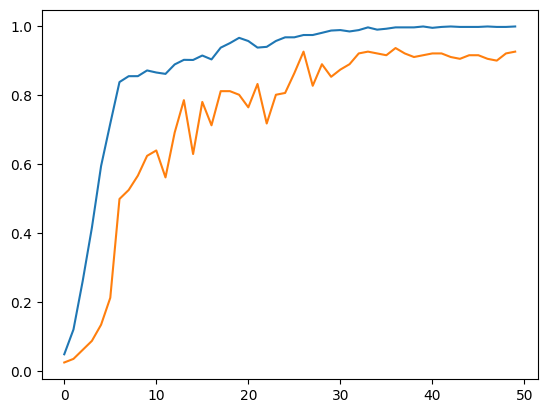

In [19]:
plt.plot(train_accuracy)
plt.plot(val_acc)

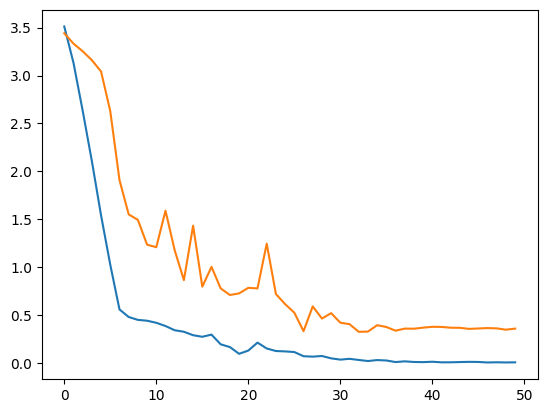

In [20]:
plt.plot(train_losses)
plt.plot(val_losses)

In [21]:
# Predict the Model
def predict(model, img, label):
  model.eval()
  with torch.no_grad():
    img = img.unsqueeze(0).to(device)
    output = model(img)
    pred = torch.argmax(F.softmax(output, dim=1)).cpu().item()
  return pred

test_predict = []
true_label = []

for i in range(len(test_set)):
  img, label = test_set[i]
  prediction = predict(model, img, label)
  test_predict.append(prediction)
  true_label.append(label)

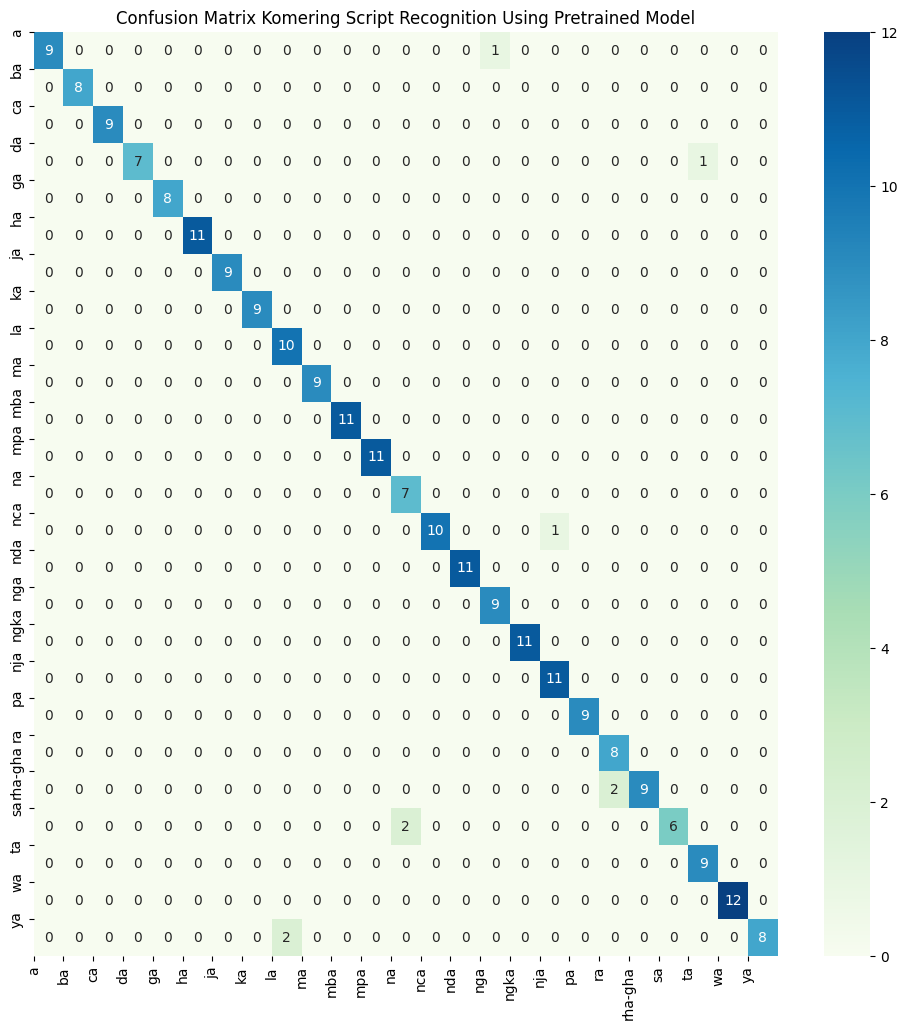

In [22]:
# Confusion Matrix
plt.figure(figsize=(12, 12))
sns.heatmap(confusion_matrix(true_label, test_predict), annot=True, cmap='GnBu')
plt.xticks(ticks=np.arange(0, len(list(dicts.keys()))), labels = list(dicts.keys()), rotation=90)
plt.yticks(ticks=np.arange(0, len(list(dicts.keys()))), labels = list(dicts.keys()))
plt.title('Confusion Matrix Komering Script Recognition Using Pretrained Model')
plt.show()

In [23]:
print(classification_report(true_label, test_predict))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         9
           3       1.00      0.88      0.93         8
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00         9
           7       1.00      1.00      1.00         9
           8       0.83      1.00      0.91        10
           9       1.00      1.00      1.00         9
          10       1.00      1.00      1.00        11
          11       1.00      1.00      1.00        11
          12       0.78      1.00      0.88         7
          13       1.00      0.91      0.95        11
          14       1.00      1.00      1.00        11
          15       0.90      1.00      0.95         9
          16       1.00      1.00      1.00        11
          17       0.92    

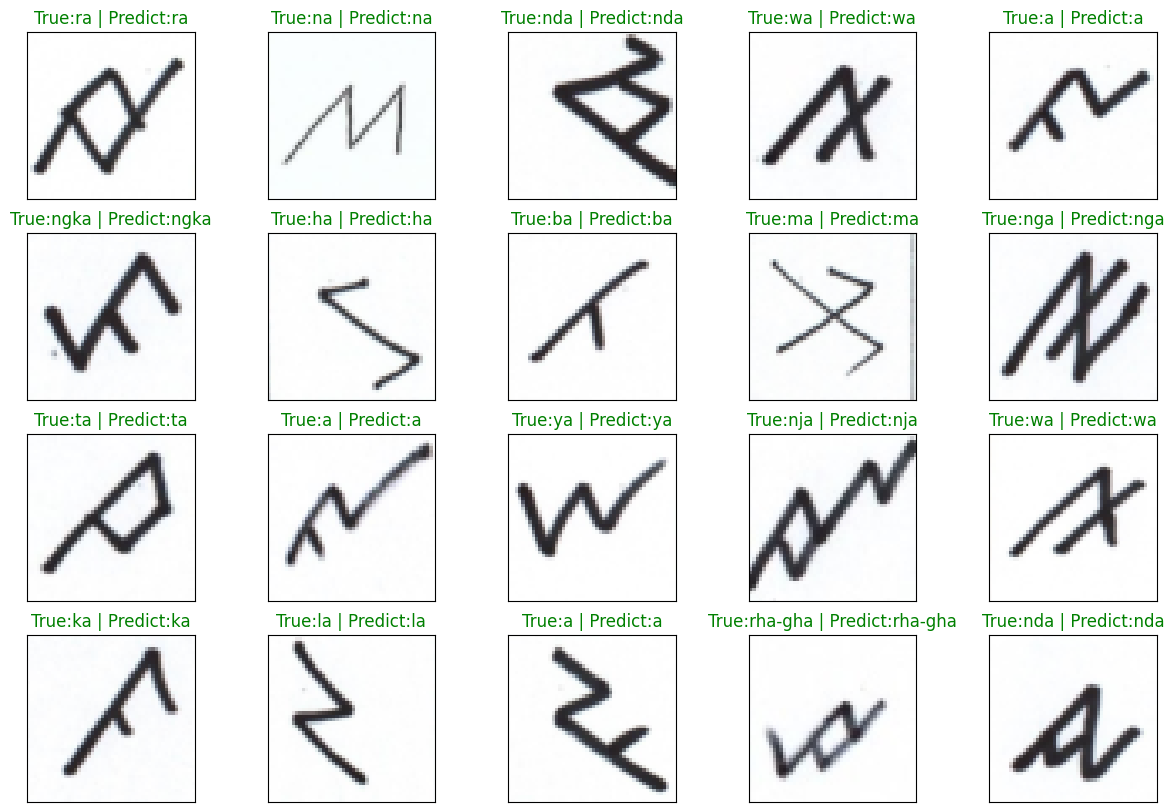

In [24]:
# Define the label list
labels = ['a', 'ba', 'ca', 'da', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'mba',
         'mpa', 'na', 'nca', 'nda', 'nga', 'ngka', 'nja', 'pa', 'ra', 'rha-gha',
         'sa', 'ta', 'wa', 'ya']

# Create a dictionary for label-to-index mapping
label_to_index = {label: i for i, label in enumerate(labels)}

def index_to_label(x):
    return labels[x]

random_selection = np.random.randint(0, len(test_predict), 20)

fig = plt.figure(figsize=(15, 10))

for i, idx in enumerate(random_selection):
    image, label = test_set[idx]
    ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title('True:{} | Predict:{}'.format(index_to_label(label), index_to_label(test_predict[idx])),
                 color=("green" if label == test_predict[idx] else 'red'), fontsize=12)

# plt.tight_layout()  # Commented out as per your request
plt.show()

In [25]:
# Save the model

torch.save(model.state_dict(), '/content/drive/MyDrive/Proyek/Computer Vision/Komering Character/model/komering_character_resnet18.pth')

In [26]:
# Assuming your model is named 'model'
model_state_dict = model.state_dict()

# Convert the state dictionary to a regular Python dictionary
model_dict = {k: v.cpu().numpy().tolist() for k, v in model_state_dict.items()}

# Save the dictionary as a JSON file
with open('/content/drive/MyDrive/Proyek/Computer Vision/Komering Character/model/komering_character_resnet18.json', 'w') as f:
    json.dump(model_dict, f)


In [31]:
import gradio as gr
import numpy as np

# Load the model with the correct output features (25 classes)
model_deployment = models.resnet18(pretrained=True)
model_deployment.fc = nn.Linear(in_features=512, out_features=len(dicts), bias=True)

# Load the saved state dictionary
model_deployment.load_state_dict(torch.load('/content/drive/MyDrive/Proyek/Computer Vision/Komering Character/model/komering_character_resnet18.pth', map_location=device))
model_deployment.to(device)
model_deployment.eval()

# Define the labels list and index_to_label function again for the Gradio app
labels_gradio = ['a', 'ba', 'ca', 'da', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'mba',
                 'mpa', 'na', 'nca', 'nda', 'nga', 'ngka', 'nja', 'pa', 'ra', 'rha-gha',
                 'sa', 'ta', 'wa', 'ya']

def index_to_label_gradio(idx):
    return labels_gradio[idx]

# Define the prediction function for Gradio
def predict_gradio(image: np.ndarray):
    # Handle case where no image is uploaded or it's not a numpy array (e.g., placeholder from Gradio)
    if image is None or not isinstance(image, np.ndarray):
        return {label: 0.0 for label in labels_gradio}

    # Convert numpy array from Gradio Image upload to PIL Image
    pil_image = Image.fromarray(image.astype('uint8'), 'RGB')

    # Apply the validation transform (resize and ToTensor) to the input image
    # Note: val_transform was defined earlier as: T.Compose([T.Resize((50, 50)), T.ToTensor()])
    transformed_image = val_transform(pil_image)

    # Add a batch dimension and move to device
    input_tensor = transformed_image.unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        output = model_deployment(input_tensor)
        probabilities = F.softmax(output, dim=1)
        predicted_index = torch.argmax(probabilities, dim=1).item()

    # Convert predicted index to label string
    predicted_label = index_to_label_gradio(predicted_index)

    # Return a dictionary of class probabilities for Gradio's Label output
    confidences = {labels_gradio[i]: float(probabilities[0, i]) for i in range(len(labels_gradio))}
    return confidences

# Create the Gradio interface
iface = gr.Interface(fn=predict_gradio,
                   inputs=gr.Image(type="numpy", label="Upload Komering Script Image"),
                   outputs=gr.Label(num_top_classes=5, label="Prediction"),
                   title="Komering Script Character Recognition (Image Upload)",
                   description="Upload an image of a Komering script character to get its prediction.")

# Launch the interface
iface.launch(debug=True, share=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://29ce496b7cadf8dca3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/tmp/ipython-input-3678415017.py:28: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil_image = Image.fromarray(image.astype('uint8'), 'RGB')
/tmp/ipython-input-3678415017.py:28: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil_image = Image.fromarray(image.astype('uint8'), 'RGB')
/tmp/ipython-input-3678415017.py:28: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil_image = Image.fromarray(image.astype('uint8'), 'RGB')
/tmp/ipython-input-3678415017.py:28: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil_image = Image.fromarray(image.astype('uint8'), 'RGB')
/tmp/ipython-input-3678415017.py:28: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil_image = Image.fromarray(image.astype('uint8'), 'RGB')
/tmp/ipython-input-3678415017.

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://29ce496b7cadf8dca3.gradio.live


In [34]:
# Save the model in ONNX format
# Define a dummy input for ONNX export
# The input size should match the model's expected input (e.g., 1 batch, 3 channels, 50x50 pixels)
dummy_input = torch.randn(1, 3, 50, 50).to(device)

# Path to save the ONNX model
onnx_model_path = '/content/drive/MyDrive/Proyek/Computer Vision/Komering Character/model/komering_character_resnet18.onnx'

# Export the model
torch.onnx.export(model,
                  dummy_input,
                  onnx_model_path,
                  export_params=True,
                  opset_version=11,
                  do_constant_folding=True,
                  input_names=['input'],
                  output_names=['output'],
                  dynamic_axes={'input': {0: 'batch_size'},
                                'output': {0: 'batch_size'}})

print(f"Model successfully exported to ONNX format at: {onnx_model_path}")

/tmp/ipython-input-3074708003.py:10: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(model,
W1122 05:34:41.966000 9193 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 11 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/adapters/axes_input_to_attribute.h:65: adapt: Asserti

Applied 40 of general pattern rewrite rules.
Model successfully exported to ONNX format at: /content/drive/MyDrive/Proyek/Computer Vision/Komering Character/model/komering_character_resnet18.onnx
